In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Imports
import tensorflow as tf
from tensorflow import keras
import csv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#datapath
data = "/content/drive/MyDrive/daily-minimum-temperatures-in-me.csv"

In [ ]:
#Split data
temperature = []

with open(data) as file:
  reader = csv.reader(file, delimiter=",")
  next(reader)
  for row in reader:
    try:
      temperature.append(float(row[1]))
    except IndexError:
      pass
    except ValueError:
      pass

#create list for time steps
time_steps = [i for i in range(len(temperature))]

In [ ]:
#convert the lists to array
series = np.array(temperature)
time = np.array(time_steps)

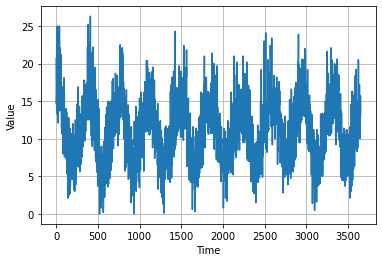

In [ ]:
#plot the series
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [ ]:
#split data
split_time = 3000

time_train = time[:3000]
x_train = series[:3000]

time_val = time[3000:]
x_val = series[3000:]

In [ ]:
#Set parameteres for data windowing
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
#series to windowed dataset LSTM
def window_data_LSTM(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
#series to windowed dataset CONVOLUTION
def window_data_CONV(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
train_data = window_data_LSTM(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

In [ ]:
#build the model
model = keras.models.Sequential([
                                 keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                 keras.layers.LSTM(64, return_sequences=True),
                                 keras.layers.LSTM(64),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

In [ ]:
lr_sheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
model.compile(loss=keras.losses.Huber(), metrics=["mae"], optimizer="adam")

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
history = model.fit(train_data, epochs=100, callbacks=[lr_sheduler])

Epoch 1/100
93/93 [==============================] - 3s 8ms/step - loss: 216.1185 - mae: 216.6185
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 215.4117 - mae: 215.9117
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 215.8613 - mae: 216.3613
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 215.4134 - mae: 215.9134
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 216.2064 - mae: 216.7064
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 215.0248 - mae: 215.5248
Epoch 7/100
93/93 [==============================] - 1s 8ms/step - loss: 215.1748 - mae: 215.6748
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 215.1294 - mae: 215.6294
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 214.3195 - mae: 214.8195
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 214.3134 - mae: 214.8134
Epoch 11/100
93/93 

(1e-08, 0.0001, 0.0, 60.0)

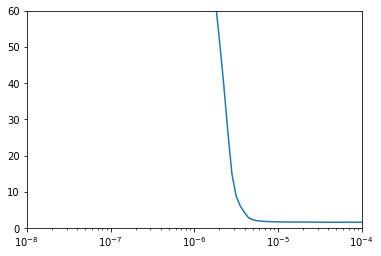

In [ ]:
learning_rate = history.history["lr"]
loss = history.history["loss"]
plt.semilogx(learning_rate, loss)
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
optimizer = keras.optimizers.Adam(lr=1e-6)

In [ ]:
model.compile(loss=keras.losses.Huber(), metrics=["mae"], optimizer=optimizer)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
history = model.fit(train_data, epochs=100)

Epoch 1/100
93/93 [==============================] - 4s 8ms/step - loss: 1.5141 - mae: 1.9612
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5251 - mae: 1.9677
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5164 - mae: 1.9593
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5479 - mae: 1.9904
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5069 - mae: 1.9493
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5323 - mae: 1.9739
Epoch 7/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5508 - mae: 1.9925
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5147 - mae: 1.9555
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5146 - mae: 1.9561
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 1.5378 - mae: 1.9820
Epoch 11/100
93/93 [==============================] - 1s 8m

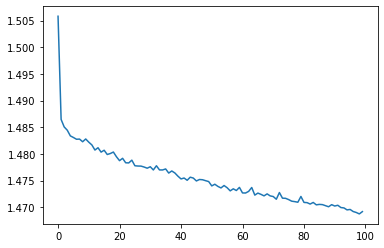

In [ ]:
loss = history.history["loss"]
plt.plot(loss)

In [ ]:
#predict the new series
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

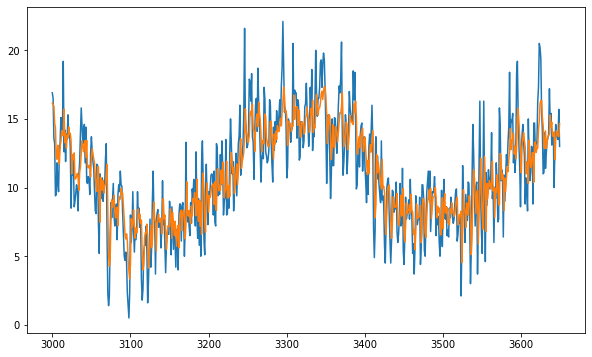

In [ ]:
#plot the predicted vs actual data
plt.figure(figsize=(10, 6))

plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [ ]:
train_data_conv = window_data_CONV(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model_conv = keras.models.Sequential([
                                      keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
                                      keras.layers.LSTM(60, return_sequences=True),
                                      keras.layers.LSTM(60),
                                      keras.layers.Dense(30, activation="relu"),
                                      keras.layers.Dense(10, activation="relu"),
                                      keras.layers.Dense(1)
])

In [ ]:
model_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          30000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 61,575
Trainable params: 61,575
Non-trainable params: 0
____________________________________________________

In [ ]:
model_conv.compile(loss=keras.losses.Huber(), metrics=["mae"], optimizer="adam")

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
history_conv = model_conv.fit(train_data_conv, epochs=100, callbacks=[lr_sheduler])

Epoch 1/100
93/93 [==============================] - 3s 8ms/step - loss: 10.4536 - mae: 10.9520
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 10.5399 - mae: 11.0392
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 10.5471 - mae: 11.0465
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 10.4167 - mae: 10.9158
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 10.4558 - mae: 10.9545
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 10.5375 - mae: 11.0364
Epoch 7/100
93/93 [==============================] - 1s 8ms/step - loss: 10.5442 - mae: 11.0431
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 10.4899 - mae: 10.9889
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 10.4982 - mae: 10.9977
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 10.5730 - mae: 11.0719
Epoch 11/100
93/93 [===================

(1e-08, 0.0001, 0.0, 60.0)

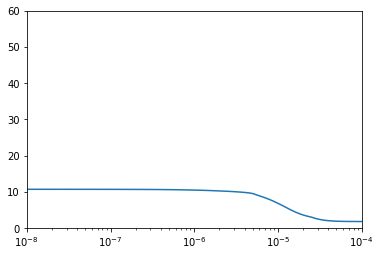

In [ ]:
learning_rate = history_conv.history["lr"]
loss = history_conv.history["loss"]
plt.semilogx(learning_rate, loss)
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
optimizer = keras.optimizers.Adam(lr=1e-4)
model_conv.compile(loss=keras.losses.Huber(), metrics=["mae"], optimizer=optimizer)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
history_conv = model_conv.fit(train_data_conv, epochs=100)

Epoch 1/100
93/93 [==============================] - 4s 8ms/step - loss: 1.5068 - mae: 1.9436
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4973 - mae: 1.9376
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 1.4644 - mae: 1.9019
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4362 - mae: 1.8720
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4771 - mae: 1.9168
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4694 - mae: 1.9069
Epoch 7/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4795 - mae: 1.9172
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4481 - mae: 1.8872
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 1.4907 - mae: 1.9295
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 1.4783 - mae: 1.9179
Epoch 11/100
93/93 [==============================] - 1s 8m

In [ ]:
def cnn_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model_conv.predict(ds)
  return forecast

In [ ]:
rnn_forecast = cnn_forecast(model_conv, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

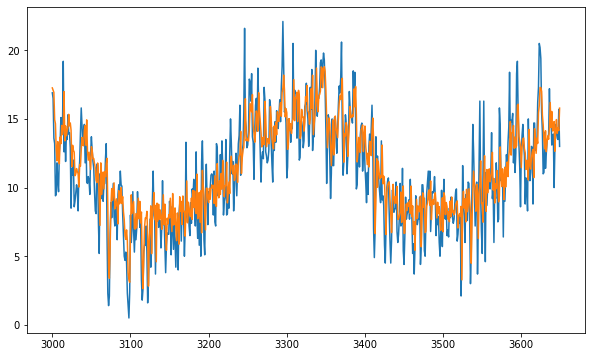

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(time_val, x_val)
plt.plot(time_val, rnn_forecast)